# Import Packages

In [109]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text pre-processing
import re
import gensim
from gensim.parsing.porter import PorterStemmer
stop_list = gensim.parsing.preprocessing.STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# for fuzzy matching of company names
from rapidfuzz import process, fuzz

# for removal of role phrases
from flashtext import KeywordProcessor

# for saving and loading data
import pickle

# Import Data

In [3]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: C:\Users\TYY\Desktop\MITB Modules\ISSS609 Text Analytics\Group Project\Doc Retrieval


In [13]:
data_directory = os.path.join(current_directory, 'data')
print("Input data directory:", data_directory)

Input data directory: C:\Users\TYY\Desktop\MITB Modules\ISSS609 Text Analytics\Group Project\Doc Retrieval\data


In [7]:
output_directory = os.path.join(current_directory, 'output')
print("Output data directory:", output_directory)

Output data directory: C:\Users\TYY\Desktop\MITB Modules\ISSS609 Text Analytics\Group Project\Doc Retrieval\output


In [15]:
# Read processed data
job_path = os.path.join(data_directory, 'data_cleaned_1.csv')
jobs_df = pd.read_csv(job_path)

In [17]:
# Drop 6 records where description is all Chinese (resulting in NA after cleaning)
jobs_df = jobs_df.dropna(subset=["processed_title+desc"])
print(jobs_df.isna().sum())

job_id                      0
job_title                   0
company                     0
descriptions                0
State                       0
merged_category             0
category                    0
subcategory                 0
role_clean                  0
type_clean                  0
salary                  35496
processed_title+desc        0
processed_text              0
dtype: int64


In [19]:
# convert "type_clean" into list
jobs_df["type_clean"] = jobs_df["type_clean"].str.lower().str.split(", ").apply(list)

# Clean `company` Field and Create Gazatteer (`companies`)
The cleaned `company_clean` field will be part of the jobs_df data for filtering later after matches are found  
The deduplicated `company_clean` values will become the gazatteer (`companies`)

In [22]:
def normalize_text_company(text):
    text = text.lower()                                    # lowercase
    text = re.sub(r'\([^)]*\)|\[[^\]]*\]', "", text)       # remove text within parenthesis or square brackets
    text = re.sub(r'&', 'and', text)                       # convert & to and
    text = re.sub(r'malaysia|sdn|bhd|sb| s b|berhad|pte|plt|pty|group|holdings|co\.|ltd\.| ltd', '', text).strip()
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # keep letters & numbers only
    text = re.sub(r'\s+', ' ', text).strip()               # normalize spaces

    if re.fullmatch(r'\d+', text):
        return ""   # clean off entire field if all only digits (12 digit numbers is the Malaysian company reg no. but no use here)
    
    return text

jobs_df['company_clean'] = jobs_df['company'].apply(normalize_text_company)
jobs_df['company_clean'] = jobs_df['company_clean'].replace('', 'nil')

In [24]:
# Create gazatteer as a list
companies = jobs_df['company_clean'].unique()
companies.sort()

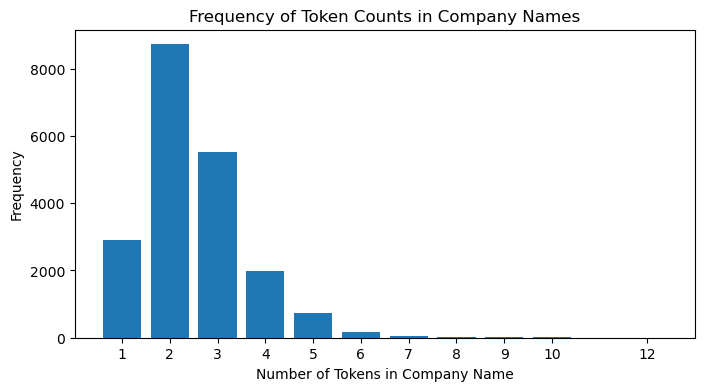

In [26]:
# Check the normal length of company names (see what is the N in N-grams)
# Maybe good enough to just check until trigrams for company name fuzzy search
company_df = pd.DataFrame(companies)
company_df.columns = ["name"]
company_df['name_length'] = company_df["name"].str.split().str.len()

# Count frequency of each token_count value
freq = company_df["name_length"].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(freq.index, freq.values)
plt.xticks(freq.index)  # exact integer ticks
plt.xlabel("Number of Tokens in Company Name")
plt.ylabel("Frequency")
plt.title("Frequency of Token Counts in Company Names")
plt.show()

In [ ]:
# Export out cleaned data to check gazatteer quality
# company_df.to_csv('company_1.csv', index=False)

In [28]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65076 entries, 0 to 65076
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   job_id                65076 non-null  int64 
 1   job_title             65076 non-null  object
 2   company               65076 non-null  object
 3   descriptions          65076 non-null  object
 4   State                 65076 non-null  object
 5   merged_category       65076 non-null  object
 6   category              65076 non-null  object
 7   subcategory           65076 non-null  object
 8   role_clean            65076 non-null  object
 9   type_clean            65076 non-null  object
 10  salary                29580 non-null  object
 11  processed_title+desc  65076 non-null  object
 12  processed_text        65076 non-null  object
 13  company_clean         65076 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.4+ MB


# Build Word2Vec + Cosine Similarity Doc Retrieval Pipeline

In [30]:
# Prepare a text field for indexing
# Try using processed_title+desc field first, the others (e.g. State, merged_category, role_clean, type_clean is for our filters)
doc_ids = jobs_df["job_id"].tolist()

tokenized_docs = [doc.split() for doc in jobs_df["processed_title+desc"]]

## Train Word2Vec Model using Corpus  
Follow example code given in https://radimrehurek.com/gensim/models/word2vec.html to build Word2Vec Embeddings

In [32]:
# Import required packages
from gensim.models.phrases import Phrases, Phraser

Train a multi-gram model to automatically detect phrases longer than one word using Phrases Gensim module  
After this can learn a word2vec model where “words” are actually multiword expressions, such as new_york_times or financial_crisis  
https://radimrehurek.com/gensim/models/word2vec.html#embeddings-with-multiword-ngrams   
  
First, investigate ideal parameters for Phrases model (bigram detector)

In [79]:
test_text = 'procurement executive contract coca cola bottler sdn bhd description position purpose manage aspect procurement supplier management contract management vendor performance tracking support administration management procurement process includes setting maintaining administering purchasing database developing issuing purchase order maintain contract log providing support department within organization'
test_text = test_text.split()

In [80]:
# To find out best params, take a sample of the corpus and try different thresholds
# threshold 10 has better clarity, (e.g. purchase_order), but misses out on other word pairs (e.g. procurement_executive)
sample_docs = tokenized_docs[:5000]

for t in [3, 5, 10, 20, 30]:
    phrases = Phrases(sample_docs, min_count=5, threshold=t, delimiter="_")
    bigram = Phraser(phrases)

    example = test_text
    print(f"\nthreshold={t}:", bigram[example])


threshold=3: ['procurement_executive', 'contract', 'coca', 'cola', 'bottler', 'sdn_bhd', 'description', 'position', 'purpose', 'manage_aspect', 'procurement', 'supplier', 'management', 'contract', 'management', 'vendor', 'performance', 'tracking', 'support', 'administration_management', 'procurement_process', 'includes', 'setting', 'maintaining', 'administering', 'purchasing', 'database', 'developing', 'issuing_purchase', 'order', 'maintain', 'contract', 'log', 'providing_support', 'department', 'within_organization']

threshold=5: ['procurement_executive', 'contract', 'coca', 'cola', 'bottler', 'sdn_bhd', 'description', 'position', 'purpose', 'manage_aspect', 'procurement', 'supplier', 'management', 'contract', 'management', 'vendor', 'performance', 'tracking', 'support', 'administration', 'management', 'procurement_process', 'includes', 'setting', 'maintaining', 'administering', 'purchasing', 'database', 'developing', 'issuing_purchase', 'order', 'maintain', 'contract', 'log', 'prov

In [81]:
# View bigrams detected at low counts to see where to cut off
# I tried 5, 10, 15, 20, 30, 40, 50, 60, 70. This param doesnt make a difference
# We dont have low frequency bigrams to remove, can leave min_count at default 5.
sample_docs = tokenized_docs[:5000]

for c in [50, 60, 70]:
    phrases = Phrases(sample_docs, min_count=c, threshold=10, delimiter="_")
    print(f"\nmin_count={c}")
    pairs=phrases.export_phrases()
    top = sorted(pairs.items(), key=lambda x: x[1])[:20]
    for phrase, score in top:
        print(f"{phrase}   score={score:.2f}")


min_count=50
ensuring_compliance   score=10.02
back_end   score=10.05
make_recommendation   score=10.07
business_analyst   score=10.22
daily_operation   score=10.27
develop_maintain   score=10.30
office_supply   score=10.42
interpersonal_ability   score=10.46
candidate_must   score=10.53
process_improvement   score=10.75
related_matter   score=10.83
training_program   score=10.96
within_organization   score=10.99
individual_join   score=11.02
perform_duty   score=11.06
join_team   score=11.45
literate_microsoft   score=11.52
financial_reporting   score=11.73
build_relationship   score=11.79
basic_salary   score=11.96

min_count=60
accurate_record   score=10.03
duty_may   score=10.16
network_security   score=10.17
manage_multiple   score=10.19
process_improvement   score=10.19
related_matter   score=10.20
mandarin_added   score=10.26
area_improvement   score=10.26
general_administrative   score=10.54
join_team   score=10.87
standard_operating   score=10.92
financial_reporting   score=1

Create Phrases Model (Bigram detector)  
Note: First Phrases call detects bigrams. To get trigrams or higher, stack Phrases models.

In [34]:
phrases = Phrases(tokenized_docs, min_count=5, threshold=10, delimiter="_") # Learn which word pairs form phrases
bigram = Phraser(phrases) # Convert to efficient transformer
processed_docs = [bigram[t] for t in tokenized_docs] # Apply model

Apply the trained Bigram detector to my corpus, using the result to train a Word2vec model   
Note: Training took about 5 min

In [36]:
from gensim.models import Word2Vec

In [38]:
model = Word2Vec(
    sentences=processed_docs,
    vector_size=300, # common default
    window=5, # controls how many words left & right count as context
    min_count=5, # Based on EDA for TF-IDF, words with frequencies below 5 are usually mispellings, Malay words
    sg=1, # Use skipgram coz we are not asking model to fill in the blanks, we ask model to predict the related words around the technical terms (e.g. what words are Kubernetes, ETL related to)
    seed=42
)

Save model and lightweight vectors upon training

In [40]:
# Save the bigram model
bigram_model_path = os.path.join(output_directory, "bigram_phraser.model") # save bigram model
bigram.save(bigram_model_path)

# Save the trained Word2Vec model
full_model_path = os.path.join(output_directory, "word2vec.model") # Save full model (trainable)
model.save(full_model_path)

vectors_path = os.path.join(output_directory, "word2vec.wordvectors") # Save lightweight vectors for inference
model.wv.save(vectors_path)

For future sessions, just load the models directly

In [42]:
# Loading of bigram model
bigram = Phraser.load(os.path.join(output_directory, "bigram_phraser.model"))

# Process tokenised docs using the same bigram model
# processed_docs = [bigram[t] for t in tokenized_docs]

In [44]:
# Load W2V full model
model = Word2Vec.load(os.path.join(output_directory, "word2vec.model"))

In [48]:
# Load lightweight vectors
from gensim.models import KeyedVectors
wv = KeyedVectors.load(os.path.join(output_directory, "word2vec.wordvectors"), mmap='r')

In [50]:
# Test loaded models and weighted vectors
print(model.wv['python'][:5])   # vector from full model
print(wv['python'][:5])         # vector from lightweight KeyedVectors

[-0.2242608  -0.26031297  0.40079248 -0.04101113 -0.3963683 ]
[-0.2242608  -0.26031297  0.40079248 -0.04101113 -0.3963683 ]


## Create Document Vectors using Trained Word2Vec Model
Word2Vec gives us a vector per word, not for the whole document. To represent the document itself as a single embedding, we need to combine those word vectors into one vector. This is called pooling.  

In contrast, TF-IDF already produces a document vector.

The most common methods are:
1. Averaging Word Vectors: Retrieve the pre-trained Word2Vec vector for each word in the document. Sum these word vectors and divide the sum by the number of words in the document to obtain the average vector.
2. TF-IDF Weighted Averaging: Calculate the TF-IDF score for each word in the document. Multiply each word's Word2Vec vector by its corresponding TF-IDF score. Sum these weighted vectors and then average them, or simply sum them to get a weighted sum vector.

We will try the 2nd method as it sounds more reasonable.

In [52]:
# Import required packages for TF-IDF
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [54]:
# Build dictionary using processed_docs which already has bigrams inside
dct = Dictionary(processed_docs)

In [56]:
# Extract the frequency of each word in the corpus
doc_freq = [(dct[id], freq) for id, freq in dct.dfs.items()]
freq_df = pd.DataFrame(doc_freq, columns=["token", "doc_freq"]).sort_values("doc_freq", ascending=False)

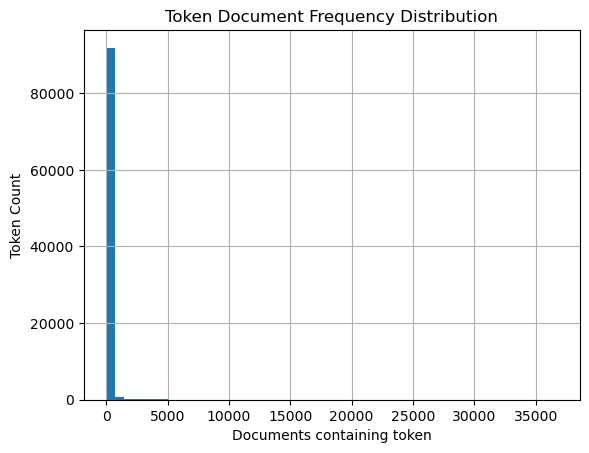

In [58]:
# Plot histogram to see proportion of rare vs common words
## Rare words are those that have few documents containing them (left side of x axis)
## Common words are those that have lots of documents containing them (right side of x axis)
## We can see that we have lots of rare words, which is good for document retrieval
## We might want to remove the common words from our Dictionary vocabulary as they will return in most of our search results
freq_df["doc_freq"].hist(bins=50)
plt.xlabel("Documents containing token")
plt.ylabel("Token Count")
plt.title("Token Document Frequency Distribution")
plt.show()

In [ ]:
# Frequent words are a combination of stop words but further down it gets less generic
# Most frequent words appear in 56% of the documents
# Can remove all words up to "able" (17270 docs / 65872 docs = 0.26)
# Note: The % went down coz some of the words became bigrams
pd.set_option('display.max_rows', None)
print(freq_df.head(100))

              token  doc_freq
8        management     37128
43             team     35884
226         working     30435
118        business     30083
12          support     28427
88          service     27613
259        customer     26272
14          process     25507
295   communication     25236
63           report     24313
509          system     23942
155         related     23934
241        required     23163
681     development     22639
85          product     22155
486         project     21828
816     description     21577
506            role     21154
40             time     20924
229         ability     20472
152          assist     20250
24         maintain     20039
5            manage     19838
330        industry     19744
48        operation     19672
148     responsible     19548
124     environment     19514
120        relevant     19283
49         activity     18931
310     information     18425
551         manager     18419
106   qualification     18279
1         

In [ ]:
# rare words are actually mispellings
print(freq_df.tail(100))

                     token  doc_freq
20210             feed_epc         1
20211                 ukoc         1
20212           hierarchic         1
20227              andling         1
70629                tekno         1
70628                fromt         1
70627             nalytics         1
70626                ibeli         1
70625        satisfication         1
70622             dimploma         1
45915                 dpvc         1
70686               aarasz         1
45890              redtone         1
70689              adorned         1
70693                compo         1
70732            paymentto         1
70731            relatedto         1
70729            alphonsus         1
70728             proquest         1
70727              incites         1
70724                  enc         1
70723              mandari         1
70721                  lne         1
70720                  qaa         1
45885           snorkelers         1
70712           moneysmart         1
7

In [ ]:
# Find where's the best cut off, inspect via Excel
# From inspection, after freq 4 onwards, the words have less mispellings and Malay words
# There are more rare but meaningful bigrams now
rare_df = freq_df[freq_df["doc_freq"] <= 10].sort_values("doc_freq")
rare_df.to_csv("rare_tokens_w2v.csv", index=False)

In [ ]:
# Reset back setting
pd.reset_option('display.max_rows')

In [60]:
# Prune extremes based on EDA above
dct.filter_extremes(no_below=4, no_above=0.26)

In [62]:
# save dictionary 
dct_path = os.path.join(output_directory, "dct_filtered.dict")
dct.save(dct_path)

In [64]:
# Test load of dictionary
from gensim.corpora import Dictionary
dct = Dictionary.load(os.path.join(output_directory, 'dct_filtered.dict'))

In [66]:
# BOW Corpus
corpus_bow = [dct.doc2bow(tokens) for tokens in processed_docs]

In [68]:
# Fit TF-IDF model on the corpus
tfidf = TfidfModel(corpus=corpus_bow)

In [70]:
# Save TF-IDF model
tfidf_path = os.path.join(output_directory, "tfidf_model.tfidf")
tfidf.save(tfidf_path)

In [72]:
# Test load of TF-IDF model
tfidf = TfidfModel.load(os.path.join(output_directory, "tfidf_model.tfidf"))

In [74]:
# Function to compute a single doc vector
# doc_tokens is a list of words (aka tokens) of a document, we process 1 document at a time

def tfidf_weighted_doc_vector(doc_tokens, wv, dictionary, tfidf_model):
    bow = dictionary.doc2bow(doc_tokens) # Use the passed in TF-IDF dictionary to convert the document's tokens into BOW representation
    tfidf_weights = dict(tfidf_model[bow])  # Convert list of tuples to dict for fast lookup {token_id: weight}

    # Init the output vector to be of same dimension as wv vector size, with initial value is 0
    weighted_sum = np.zeros(wv.vector_size, dtype=np.float32)
    weight_total = 0.0 # This is just a validation checker

    # iterate over unique tokens in the doc (compiled from the tfidf_weights)
    for token_id, weight in tfidf_weights.items():
        token = dictionary[token_id] # get the word based on its token_id
        if token in wv: # Find the word in my lightweight vectors, wv
            weighted_sum += weight * wv[token] # Get the word embedding for this word, weighted by importance from TF-IDF model
            weight_total += weight

    if weight_total > 0:
        return (weighted_sum / weight_total).astype(np.float32) # Compute weighted average
    else: # if none of the tokens are in the W2V model's vocab, return zero vector (which is orthogonal and will result in 0 for any cosine similarity) 
        return np.zeros(wv.vector_size, dtype=np.float32)

In [76]:
# Check vector size
vector_size = wv.vector_size
print(vector_size)

300


In [78]:
# Build document vector for each document in processed_docs (aligned with doc_ids / jobs_df index)
# Stack them vertically into one matrix, so each row is a document vector, and the cols are the word vector dimension (300 cols)
doc_embeddings = np.vstack([
    tfidf_weighted_doc_vector(doc, wv, dct, tfidf)
    for doc in processed_docs
])

In [80]:
# Normalise doc_embeddings so that longer documents are penalised
def _l2_normalize_rows(X, eps=1e-12):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps) # Avoids divide by zero error in next line if document vector is all zeros
    return X / norms

def _l2_normalize_vec(v, eps=1e-12):
    n = np.linalg.norm(v)
    if n < eps:
        return v  # zero vector stays zero early return, no need divide by zero (cause error)
    return v / n

In [82]:
doc_embeddings_norm = _l2_normalize_rows(doc_embeddings) 

In [84]:
with open(os.path.join(output_directory, 'doc_embeddings_norm.pkl'), 'wb') as file:
    pickle.dump(doc_embeddings_norm, file)

## Build Inverted Index

In [86]:
from collections import defaultdict

In [88]:
postings = defaultdict(list)   # Format is token_id: [doc_id, doc_id, ...] (list of doc ids)

for doc_id, doc_tokens in enumerate(processed_docs):
    bow = dct.doc2bow(doc_tokens)   # Convert each doc into BOW (token_id, tid, with term frequency, tf)
    for tid, _tf in bow: # for each token (token id) in the doc, tally with the postings dict
        postings[tid].append(doc_id)

# For each token_id, sort the doc_ids within
for tid in postings:
    postings[tid].sort()

In [90]:
# Test if inverted index is correctly constructed
# First word: acknowledgment
print(dct.id2token[1])

acknowledgment


In [92]:
# Find documents with this word
# Document 0, 242 has it
postings[1][0:2]

[0, 242]

In [ ]:
# Verified doc 0 and 242 have this word
processed_docs[242]

['admin_assistant',
 'team',
 'doctor_anywhere',
 'operation',
 'team',
 'crucial',
 'part',
 'day_day',
 'excellence_tpa',
 'business',
 'virtual',
 'person',
 'clinical',
 'service',
 'resolving',
 'operational',
 'issue',
 'timely_manner',
 'providing',
 'best',
 'customer',
 'possible',
 'make_sure',
 'customer',
 'remain',
 'top_priority',
 'role',
 'senior',
 'admin_assistant',
 'play_vital',
 'role',
 'ensuring',
 'financial_stability',
 'efficiency',
 'clinic',
 'business',
 'closely',
 'claim',
 'team',
 'contribute',
 'reporting',
 'activity',
 'ideal',
 'mindset',
 'continuous_improvement',
 'demonstrate',
 'curiosity',
 'collaboration',
 'ability',
 'deal_ambiguity',
 'especially',
 'start',
 'environment',
 'role',
 'based',
 'report',
 'directly',
 'manager',
 'claim',
 'summary',
 'key',
 'follows',
 'perform',
 'various',
 'claim',
 'administrative_clerical',
 'task',
 'perform',
 'general_clerical',
 'duty',
 'claim',
 'registration',
 'filing',
 'scan',
 'supporting_d

In [94]:
# Save inverted index with pkl
inverted_index_path = os.path.join(output_directory, 'inverted_index_w2v.pkl')

with open(inverted_index_path, 'wb') as file:
    pickle.dump(postings, file)

In [ ]:
# # To load it again later
# with open(os.path.join(output_directory, 'inverted_index_w2v.pkl'), 'rb') as file:
#     postings = pickle.load(file)

## Create Categorical Filters

No change to this code, same as TF-IDF pipeline

In [96]:
# list all values in each of the categorical fields we are using for filter in Series format
state_arr = jobs_df["State"].astype(str).values
type_arr = jobs_df["type_clean"].values
merged_category_arr = jobs_df["merged_category"].astype(str).values

N = len(processed_docs) # Size of the corpus

In [98]:
# Assume data passed in already has validity checks on Front End
def facet_mask(state=None, job_type=None, merged_category=None):
    m = np.ones(N, dtype=bool) # Initialise an array m of all True first, assume no filters added
    if state is not None: # check if a filter was used by the user, if there is a value passed in      
        m &= (state_arr == str(state)) # check docs that fulfil the user's passed in value, reassign back to mask m
    if job_type is not None:
        if isinstance(job_type, list) and len(job_type) > 0: 
            # normalize case once
            sel = [s.lower() for s in job_type]
            m &= np.fromiter(
                (any((t.lower() in sel) for t in type_arr[i]) for i in range(N)),
                dtype=bool,
                count=N
            )
    if merged_category is not None:    
        m &= (merged_category_arr == str(merged_category))
    return m

## Query parsing

The user's query will pass through 2 separate steps, company extraction and query expansion

### Company Extraction

Try to find company names (if any) in the query. Company extraction has very different signals and we need to wipe out the role related keywords in order to find the entity, and extra terms introduced during query expansion may dirty the company name data, so the logic directly conflicts with the query expansion logic below.

In [103]:
# M'sian company names only allow letters, numbers, &, period, hyphen, ', ()
# But the useful ones are letters, numbers, & (convert to 'and')
def light_normalize(text):
    s = text.lower()
    s = re.sub(r"[^a-z0-9\s&]", " ", s) # Keep only useful characters
    s = s.replace("&", " and ") # replace & with and, similar treatment as company gazatteer
    s = re.sub(r"\s+", " ", s).strip() # collapse multiple white space if any
    return s

In [105]:
# Check for simple event template
event_pat = re.compile(r'\b(?:at|with|for|from)\s+([a-z0-9 ]{2,})$', re.I)

def event_pat_search(text):
    m = event_pat.search(text)
    return [m.group(1)] if m else []

In [111]:
# Define role stop words (this is different from the normal stop words. e.g. procurement executive apple, 
# we want 'procurement executive' to be cleaned off because these are words not used in company names)
# Cannot clean off location words as could be part of the company name (e.g. Royal Selangor Association), except "Malaysia"

# Create keyword processor using FlashText (which is a phrase matcher)
# Throw in all the role_clean values inside since it's very comprehensive, act as role_stopwords
role_keyword_processor = KeywordProcessor(case_sensitive=False)
role_keyword_list = jobs_df['role_clean'].str.lower().str.strip().dropna().tolist()
for p in role_keyword_list:
    if p:  # avoid empty strings
        role_keyword_processor.add_keyword(p, " ") # FlashText to replace with empty space (empty string doesnt work) when these phrases found

In [113]:
# Still add some custom stop words which are one-word to prevent more unintended matches to company names
# Intended result: No company matches, become general search with no company name filter.
role_stopwords = {
    "intern", "internship", "role", "roles", "job", "jobs", "position", "positions", 
    "career", "careers", "vacancy", "vacancies", "lead", "senior", "junior",
    "remote", "hybrid", "office", "hiring", "malaysia", "analyst", "scientist", "executive",
    "manager", "engineer", "developer"
}

stop_words = set(stopwords.words("english"))
role_stopwords |= stop_words # Try to remove so it will cut down on the no. of N-grams formed

# N-gram sweep required for query cases with no prepositions, like "Apple jobs", "Shopee data scientist"
# Max use trigrams because majority of company names are 3 words
def ngram_sweep(text, n_max=3):
    cleaned_text = role_keyword_processor.replace_keywords(text)
    toks = [t for t in cleaned_text.split() if t not in role_stopwords]
    cands = set()
    for n in range(1, n_max+1): # extract unigram (0-1st pos), till trigram (0-4th pos). total 6 combis
        for i in range(len(toks) - n+1):
            cands.add(" ".join(toks[i:i+n]))
    return sorted(cands, key=lambda x: (-len(x.split()), -len(x))) # sort longer N-grams first

In [115]:
def extract_companies(text):
    s = light_normalize(text)
    cand_companies = list(set(event_pat_search(s) + ngram_sweep(s))) # Get all possible company names from the 2 methods
    return cand_companies

In [117]:
# Test some queries
queries = [
    "maybank jobs",
    "jobs at apple",
    "google internship malaysia",
    "senior analyst roles at malayan banking",
    "apple singapore office hiring",
    "marketing jobs",
    "social media executive"
]

for q in queries:
    print(q, "→", extract_companies(q))

maybank jobs → ['maybank']
jobs at apple → ['apple']
google internship malaysia → ['google']
senior analyst roles at malayan banking → ['malayan', 'banking', 'malayan banking']
apple singapore office hiring → ['apple singapore', 'singapore', 'apple']
marketing jobs → []
social media executive → []


### Query Parsing and Expansion

Process the query in the same way as the documents in the corpus. Which includes the overall cleaning logic by Snekha.   

Modified `expand_query()` method to add additional pre-processing required for W2V, which is the bigram transformation.

In [119]:
# import packages to re-use functions used in cleaning text for database
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.wsd import lesk

'''
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
'''

"\nnltk.download('punkt')\nnltk.download('stopwords')\nnltk.download('wordnet')\nnltk.download('omw-1.4')\n"

In [121]:
def normalize_text(text):
    text = re.sub(r'<.*?>', ' ', text)                     # remove HTML tags
    text = re.sub(r'\\n|\n', ' ', text)                    # remove newlines
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # keep letters & numbers only
    text = text.lower()                                    # lowercase
    text = re.sub(r'\s+', ' ', text).strip()               # normalize spaces
    return text

In [123]:
stop_words = set(stopwords.words("english"))
custom_stop = {"experience","responsibilities","requirements","requirement","knowledge",
    "skill","skills","advantage","preferred","strong","good","excellent",
    "degree","diploma","bachelor","graduate","title",
    "independent","self-motivated","hardworking",
    "deadline","pressure","benefits","apply","immediately", "writing","spoken","etc","others","job","work","company",
    "candidate","menu","new","plus","years","revenue","ensure", "provide", "including", "malaysia"}
stop_words |= custom_stop
stop_words |= set(stopwords.words("indonesian")) # unable to find malay stopword, hence using indonasian which is relatively close
lemmatizer = WordNetLemmatizer()

In [125]:
# get POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

In [127]:
def expand_query(text):
    sentences = sent_tokenize(text)
    words = []
    pos_tags = []
    
    for sent in sentences:
        w = word_tokenize(sent)  
        words += w
        tags = pos_tag(w) 
        pos_tags += tags 
                        
    expanded_queries = []
    for word, pos in zip(words, pos_tags):
        pos = get_wordnet_pos(pos[1])
        synsets = wordnet.synsets(word, pos=pos)
        if synsets:
            correct_synset = lesk(words, word, pos=pos)
            if correct_synset:
                max_similarity = 0
                most_similar_synset = None
                for synset in synsets:
                    similarity = correct_synset.path_similarity(synset)
                    if similarity and similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_synset = synset
                if most_similar_synset:
                    expanded_queries += most_similar_synset.lemma_names()
            else:
                expanded_queries.append(word)
        else:
            expanded_queries.append(word)

    tokens=[]

    # include cleaning steps used to clean original database
    for word in expanded_queries: 
        w=normalize_text(word)
        if w.isalpha() and w not in stop_words:        
            lemma = lemmatizer.lemmatize(w)           
            tokens.append(lemma)

    tokens = bigram[tokens] # Apply bigram model to transform query into same representation as corpus

    return tokens

In [129]:
# text query expansion test
expand_query("procurement executive, data scientist, data analyst, fiscal and policy analyst")

['procurement',
 'procurance',
 'procural',
 'executive',
 'datum',
 'scientist',
 'datum',
 'analyst',
 'fiscal',
 'financial',
 'policy',
 'insurance',
 'analyst']

## Build candidate set

In [135]:
# Special helper function to fuzzy match candidate company names to the company gazatteer (companies)
def best_company(cand_companies, companies, cutoff=80):
    matches = [] # keep track of all successful fuzzy matches
    for cand in cand_companies: # feed all the possible candidates 
        if not cand:
            continue
            
        hits = process.extract( 
            cand,
            companies,
            scorer=fuzz.token_set_ratio
        )
        
        # keep only those >= cutoff
        for name, score, _ in hits:
            if score >= cutoff:
                # Append entire info (for troubleshooting mode)
                # matches.append({
                #     "cand": cand,
                #     "matched_company": name,
                #     "score": float(score)
                # })

                matches.append(name)
            
    return matches # Note: may be empty list

In [133]:
# # Test queries in troubleshoot mode (seems like the unigrams will result in lots of slightly less relevant matches, but at least wont accidentally filter)
# test_query = ['malayan banking', 'banking', 'malayan']
# print(best_company(test_query, companies))

[{'cand': 'malayan banking', 'matched_company': 'malayan banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'al rajhi banking and investment corporation', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal cfs personal and premier banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal cfs premier banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal wb corporate and commercial banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal wb enterprise banking', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan adhesives and chemicals', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan banking', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan energistik solutions', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan flour mills', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan racing association', 'score': 100.0}]


Note that `postings[tid]` is now a list, not a list of tuples since I removed the positions information which was redundant, so it's no longer for `d, _ in postings[tid]`...

In [137]:
def candidate_docs(query, state=None, job_type=None, merged_category=None):
    cand_companies = extract_companies(query)
    keywords = expand_query(query)

    # 1) Apply facet mask first to quickly reduce no. of documents to do keyword match on
    m = facet_mask(state=state, job_type=job_type, merged_category=merged_category)
    allowed_idx = np.flatnonzero(m) # returns indices where facet_mask is True
    allowed_set = set(allowed_idx) # Reduced candidate set for later

    # 2) Company filtering inside allowed_set. Strategy is to intersect allowed_set with company_set
    company_matches = best_company(cand_companies, companies, cutoff=80)
    if company_matches: # if there are results proceed to filter
        company_set = set(jobs_df.index[jobs_df['company_clean'].isin(company_matches)])
        allowed_set_intersect = allowed_set.intersection(company_set)
        # Only if there is intersection then we use the intersected set, else continue to use allowed_set
        if allowed_set_intersect:
            allowed_set = allowed_set_intersect  # use intersection

    # 3) Collect keyword candidates using inverted index, only keep docs in allowed_set
    cand = set()
    if keywords:
        for w in keywords:
            tid = dct.token2id.get(w) # check if word in the dictionary
            if tid is None: # Not found, ignore
                continue
            for d in postings[tid]: # if found, get the document id
                if d in allowed_set:         # check if this doc id was in the reduced candidate set already
                    cand.add(d) # If it is, add to the set() called cand
    else:
        # No keywords: candidates are all postings based on categorical filters. 
        cand = set(allowed_idx)

    return np.array(sorted(cand), dtype=int)

## Score candidates with TF-IDF cosine

In [139]:
def rank_embed_cosine(query, k=10, state=None, job_type=None, merged_category=None):
    # Narrow to candidate docs
    cand_idx = candidate_docs(query, state=state, job_type=job_type, merged_category=merged_category)
    if len(cand_idx) == 0:
        return jobs_df.iloc[[]]

    # Expand query and build query embedding (using TF-IDF–weighted Word2Vec)
    q_tokens = expand_query(query)
    q_vec = tfidf_weighted_doc_vector(q_tokens, wv, dct, tfidf)

    # Guard clause: if query embedding is zero, we can’t score meaningfully, return no results
    if np.all(q_vec == 0):
        return jobs_df.iloc[[]]

    # Compute Cosine similarity vs candidates (using normalised document embeddings)
    cand_mat = doc_embeddings_norm[cand_idx] # Filter the corpus matrix previously built for only candidates
    q_unit = _l2_normalize_vec(q_vec) # Normalise the query embedding also for equal length comparison

    sims = cand_mat @ q_unit # Can just take dot product since both vectors already normalised (i.e. the denominator of the cosine similarity formula alr done)

    # Get Top-k results by sorting in descending order of sims values
    n = sims.shape[0] # Take no. rows of sims
    if k < n:
        topk_idx = np.argpartition(-sims, k-1)[:k]
        order = topk_idx[np.argsort(-sims[topk_idx])]
    else:
        order = np.argsort(-sims)

    top_local = order
    top_scores = sims[top_local]
    top_doc_idx = cand_idx[top_local] # map back to global row indices

    # Structure output
    out = jobs_df.iloc[top_doc_idx].copy()
    out["score"] = top_scores
    out = out.sort_values("score", ascending=False)
    return out

## Example usage

In [145]:
result = rank_embed_cosine(
    "procurement executive",
    k=10,
    state="Selangor",
    job_type=['Full time']
)

result[['job_id', 'job_title', 'descriptions', 'State', 'type_clean', 'merged_category', 'score']]

,job_id,job_title,descriptions,State,type_clean,merged_category,score
1418,74562185,PROCUREMENT EXECUTIVE,JOB DESCRIPTION\nResponsible for managing the ...,Selangor,[full time],Manufacturing & Logistics,0.763764
40258,75598902,Purchasing Manager (F&B and Theme Park),The Purchasing Manager of Only World Group pla...,Selangor,[full time],Hospitality & Services,0.724805
26764,74682394,Procurement Manager,Job description\nWe are seeking an experienced...,Selangor,[full time],Manufacturing & Logistics,0.711593
46748,76041457,Purchasing Executive,Job Responsibilities:\n1.Supplier Management:\...,Selangor,[full time],Manufacturing & Logistics,0.705124
19613,72489320,Raw Material Buyer - New Product Development,Duties and Responsibilities:\nOverall project...,Selangor,[full time],Manufacturing & Logistics,0.694465
34580,75010838,"Assistant Manager, Procurement",Position Overview\nAssistant Manager of Procur...,Selangor,[full time],Manufacturing & Logistics,0.692558
5976,74421502,Procurement Manager,Key Responsibilities:\nSourcing: Identify pote...,Selangor,[full time],Engineering & Technology,0.691602
27090,74662163,Purchasing Manager,"Responsibilities:\nSourcing, selecting and neg...",Selangor,[full time],Engineering & Technology,0.690570
37188,75270534,Procurement Manager,Key Responsibilities:\nSourcing: Identify pote...,Selangor,[full time],Engineering & Technology,0.688695
19153,73932434,Procurement Manager,Responsibilities:\nDeveloping procurement stra...,Selangor,[full time],Manufacturing & Logistics,0.685835


In [149]:
# Test company fuzzy search with preposition (event template will pick this up)
result = rank_embed_cosine(
    "senior analyst roles at maybank",
    k=10,
    state="Kuala Lumpur",
    job_type=['Full time']
)

result[['job_id', 'company', 'job_title', 'descriptions', 'score']]

,job_id,company,job_title,descriptions,score
61186,83580406,Alliance Bank Malaysia Berhad,SME Sales Specialist (Fresh Graduates June Int...,Job Description:\nSME Associate is a sales rol...,0.626309
15809,72345057,PUBLIC MUTUAL BERHAD,Credit Research Analyst,Investment & Economics Research Department\nCr...,0.616476
49112,76167400,Tranglo Sdn Bhd,Treasury Specialist,"Treasury Specialist\nTranglo Sdn Bhd, a fintec...",0.613856
64480,83970395,Affin Bank Berhad,"Director/Vice President, Independent Model Val...",JOB PURPOSE\nThe role supports the Head of Mod...,0.613379
56661,82911636,Alliance Bank Malaysia Berhad,Senior Executive/Manager – Business Finance Ma...,Job Description\nGSME Financial Performance\nP...,0.609860
62657,83722784,Alliance Bank Malaysia Berhad,"Senior Executive, FRS9 Data Modeling",What you'll be doing\nDevelop and maintain com...,0.608700
11544,72345287,BUMIRIA DINAMIK SDN BHD,Corporate Banking Associate - AVP,The Associate is an intermediate-level positio...,0.607766
16695,74117573,Agensi Pekerjaan Hays (Malaysia) Sdn Bhd,"SM/VP, Independent Credit Review","Senior Manager/Vice President, Post-Approval a...",0.606597
25972,74201492,LUXOFT MALAYSIA SDN. BHD.,System Analyst (NetGuardians (IFM)),Popular Searches\nJAVA\n Senior JAVA\n PMO\n Q...,0.602662
5364,74460623,Prudential BSN Takaful Berhad,"Assistant Manager, Financial Risk Management",The financial risk management function is requ...,0.600817


In [151]:
# Test company fuzzy search without preposition (n-gram sweep will pick this up)
result = rank_embed_cosine(
    "google engineer",
    k=10
)

result[['job_id', 'company', 'job_title', 'descriptions', 'score']]

,job_id,company,job_title,descriptions,score
13069,74166152,Google Malaysia Sdn Bhd,"Field Sales Representative, Google Cloud",Qualification\nMinimum qualifications:\nBachel...,0.591234
12307,73986161,Google Malaysia Sdn Bhd,"Sales Specialist, Google Workspace",Qualification\nMinimum qualifications:\nBachel...,0.575631
23335,74457851,Google Malaysia Sdn Bhd,"Customer Solutions Consultant, Infrastructure ...",Qualification\nMinimum qualifications:\nBachel...,0.528869
20815,74641866,Google Malaysia Sdn Bhd,"Electrical Engineer, Data Center Design and Co...",Qualification\nMinimum qualifications:\nMaster...,0.449293


In [153]:
# Test general search term, whether will confuse as company name
# This query will be confused as company name as there isnt any role found (unlike "social media executive" below)
# There wont be good results because very few companies have name 'social', 'media', 'social' media which have
# "social media" in job title and description
result = rank_embed_cosine(
    "social media",
    k=10   
)

result[['job_id', 'job_title', 'company', 'descriptions', 'State', 'type_clean', 'merged_category', 'score']]

,job_id,job_title,company,descriptions,State,type_clean,merged_category,score
59083,83280378,Social Media Marketing Executive,Tong Garden Food (Malaysia) Sdn Bhd,"We are looking for a creative, detail-oriented...",Johor,[full time],Sales & Marketing,0.680289


In [155]:
# This query should have no issue, coz the role is entirely cleaned away by FlashText
result = rank_embed_cosine(
    "social media executive",
    k=10   
)

result[['job_id', 'job_title', 'company', 'descriptions', 'State', 'type_clean', 'merged_category', 'score']]

,job_id,job_title,company,descriptions,State,type_clean,merged_category,score
29615,74706483,"SENIOR EXECUTIVE, GROUP BRANDING & COMMUNICATI...",S P Setia Berhad,Assist to monitor media coverage and compile n...,Selangor,[full time],Creative & Design,0.745215
26232,74172648,Media Executive,Bluedale Integrated (M) Sdn. Bhd.,Description\nThe duties of a Media Executive i...,Selangor,[full time],Creative & Design,0.741899
14501,74038314,Business Executive - Media Sales,Bluedale Integrated (M) Sdn. Bhd.,Description\nThe duties of a Business Executiv...,Selangor,[full time],Creative & Design,0.740931
52062,76576544,"Senior Executive, Corporate Liason",LBS Bina Group Berhad,Job Description:\nBuild and maintain relations...,Selangor,[full time],Sales & Marketing,0.735955
50256,76446174,Brand Executive,Kotra Pharma (M) Sdn Bhd (Sales & Marketing Of...,Responsibilities:\nBrand custodian.\nEnsure co...,Kuala Lumpur,[full time],Sales & Marketing,0.735912
50113,76432103,Marketing Executive,Southern Score Sdn Bhd,The ideal candidate shall be an experienced an...,Kuala Lumpur,[full time],Sales & Marketing,0.735549
29080,74768570,"Senior Executive, Strategic Communications",Mah Sing Group Berhad,KEY RESPONSIBILITIES\nAssist to manage communi...,Kuala Lumpur,[full time],Sales & Marketing,0.728904
51913,76576826,"Executive, PR & Media",LBS Bina Group Berhad,Job Responsibilities:\nPrepare collaterals inc...,Selangor,[full time],Sales & Marketing,0.726578
3637,74480407,Planning & Marketing Executive,Country Garden Pacificview Sdn Bhd,Job Description:\n1. Responsible for marketing...,Johor,[full time],Creative & Design,0.724967
36486,75247275,Senior Executive Copywriter,MALAYSIA HEALTHCARE TRAVEL COUNCIL,Key Feature Of The Role\nThe Copywriter—the gr...,Kuala Lumpur,[contract/temp],Creative & Design,0.722899


In [185]:
# For evaluation
result = rank_embed_cosine(
    "logistics warehouse jobs mandarin speaking",
    k=10
)

result_clean = result[['job_id', 'job_title', 'company', 'descriptions', 'State', 'merged_category', 'type_clean', 'score']].copy()
result_clean.to_csv('result_clean.csv', index=False)